In [ ]:
! pip install langchain_community

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from abc import ABC, abstractmethod
from dataclasses import dataclass
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [17]:
class LLMInterface(ABC):
    """Abstract base class for LLM interaction"""

    @abstractmethod
    def generate(self, prompt: str) -> str:
        """Generate text based on prompt"""
        pass

# class RealLLM(LLMInterface):
class RealLLM:
    def __init__(self, model_name):
        # self.llm = OllamaLLM(model=model_name,  callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))
        self.llm = OllamaLLM(model=model_name)
        # self.llm.callback_manager = CallbackManager([
        #     StreamingStdOutCallbackHandler()
        # ])


    # async def generate(self, formatted_prompt):
    #     responses = model.generate_content(
    #         formatted_prompt,
    #         generation_config={"max_output_tokens": 256, "temperature": 0.0},
    #         # "top_p": 1}}}},
    #         stream=False,
    #     )

    #     response = responses.candidates[0].content.text
    #     return response

In [39]:
chat_history = []

In [ ]:
system_template = """If any information needs, use previous chat history
Question: {question}

Answer: """

prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_template), 
                MessagesPlaceholder(variable_name="chat_history"), 
                ("human", "{question}")
            ]
        )

RealLLM_obj = RealLLM('llama3.2')
chain = prompt | RealLLM_obj.llm

while True:
    question = input("Ask a question: ")
    if question == "exit":
        break
    responce = chain.invoke({"question": question, "chat_history": chat_history[-10:]})
    print(question)
    print(responce)
    chat_history.append("<human> " + question + "</human>")
    chat_history.append("<system> " + responce + "</system>")
    # chat_history.append(AIMessage(content=responce))
# chain.invoke({"question": "What is LangChain?"})

In [ ]:
chat_history

In [ ]:
from ollama import chat
from pydantic import BaseModel

class Country(BaseModel):
  name: str
  capital: str
  languages: list[str]

response = chat(
  messages=[
    {
      'role': 'user',
      'content': 'Tell me about Canada.',
    }
  ],
  model='llama3.2',
  format=Country.model_json_schema(),
)

country = Country.model_validate_json(response.message.content)
print(country)


In [ ]:
class Country(BaseModel):
  name: str
  capital: str
  languages: list[str]

RealLLM_obj.llm.invoke("Tell me about Canada.").with_output_parser(JsonOutputParser(Country)).output

In [7]:
from pydantic import BaseModel
from typing import List

class StructuredOutput(BaseModel):
    title: str
    summary: str
    tags: List[str]
    confidence: float



In [ ]:
if __name__ == "__main__":
    input_text = "Explain the importance of structured data in AI."
    
    try:
        result = generate_structured_output(input_text)
        # print(result.json(indent=2))  # Validated structured output
        print(result)
    except Exception as e:
        print(f"Error: {e}")


In [ ]:
# from langchain_community.llms import Ollama
from langchain_community.llms.ollama import Ollama
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

# model_name = "llama3.2"
model_name = "deepseek-r1:8b"
model = Ollama(model = model_name)

query = "The Fable of the Fox and the Crow. don't add any extra information"
class Output(BaseModel):
    names: list = Field(description = "Give me the list of all the name of the characters")
    places: list = Field(description = "Give me the list of places if it is available ")

parser = PydanticOutputParser(pydantic_object = Output)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser

result = chain.invoke({"query": query})

print(result)
# results = parser.parse(result)
print(result.places)
print(result.names)

In [ ]:
result

In [ ]:
print(result.places)
print(result.names)

In [22]:
result

Output(names=['Fox', 'Crow'], places=['village', 'fields/meadows', 'tree', 'wheat stubs'])

In [23]:
print(result.places)
print(result.names)

['village', 'fields/meadows', 'tree', 'wheat stubs']
['Fox', 'Crow']


In [6]:
import sqlite3
import requests
from bs4 import BeautifulSoup
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.graphs import Graph

class PlanExecute:
    pass


class AffiliateAgent:
    def __init__(self, db_path):
        self.db_path = db_path
        # Initialize Llama model
        self.llm = LlamaCpp(model="llama-3.2")
        self.llm_chain = LLMChain(llm=self.llm)

    def fetch_page_content(self, url):
        """Fetch the HTML content of the page."""
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        return soup.get_text()

    def parse_product_details(self, page_content):
        """Parse product details from page content using LLM."""
        prompt = """
        Given the following webpage content, extract the product details including product ID, description, 
        image URL, and offer details. Provide the output in the form of a dictionary with the following keys:
        product_id, description, image_url, offer_details.

        Webpage content:
        {content}
        """
        formatted_prompt = prompt.format(content=page_content)
        product_data = self.llm_chain.run(formatted_prompt)
        return eval(product_data)

    def store_product_in_db(self, product_data, url):
        """Store product data in SQLite database."""
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        c.execute('''INSERT OR REPLACE INTO products (product_id, url, description, image_url, offer_details)
                     VALUES (?, ?, ?, ?, ?)''',
                  (product_data['product_id'], url, product_data['description'],
                   product_data['image_url'], product_data['offer_details']))
        conn.commit()
        conn.close()

    def search_database(self, query):
        """Search for a product in the database by query."""
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        c.execute("SELECT * FROM products WHERE description LIKE ?", ('%' + query + '%',))
        results = c.fetchall()
        conn.close()
        return results

    def scrape_and_store(self, query):
        """Scrape product details from Amazon and store in the database."""
        amazon_search_url = f"https://www.amazon.in/s?k={query.replace(' ', '+')}"
        page_content = self.fetch_page_content(amazon_search_url)
        product_data = self.parse_product_details(page_content)
        self.store_product_in_db(product_data, amazon_search_url)

    def handle_user_query(self, query):
        """Handle a user's query for a product."""
        # Step 1: Search the database
        results = self.search_database(query)
        if results:
            return results

        # Step 2: Scrape and store if no results
        self.scrape_and_store(query)
        return self.search_database(query)


# --- LangGraph Visualization ---
def create_lang_graph():
    """Create and visualize the LangGraph for Affiliate Agent."""
    # graph = LangGraph("Affiliate Agent Workflow")
    graph = Graph("Affiliate Agent Workflow")
    
    # Nodes
    graph.add_node("User Query", description="User submits a query for a product.")
    graph.add_node("Search Database", description="Search for product in SQLite database.")
    graph.add_node("Log Search History", description="Log the user's query in the search history table.")
    graph.add_node("Scrape Amazon", description="Scrape Amazon for product details.")
    graph.add_node("Store in Database", description="Store the scraped product data in the SQLite database.")
    graph.add_node("Return Results", description="Return the product details to the user.")

    # Edges
    graph.add_edge("User Query", "Log Search History", "Log the query")
    graph.add_edge("User Query", "Search Database", "Search database")
    graph.add_edge("Search Database", "Return Results", "Found in DB", condition="Results Found")
    graph.add_edge("Search Database", "Scrape Amazon", "Not found in DB", condition="No Results")
    graph.add_edge("Scrape Amazon", "Store in Database", "Save scraped data")
    graph.add_edge("Store in Database", "Search Database", "Retry search")
    graph.add_edge("Search Database", "Return Results", "Found after scrape")

    return graph


# --- Main Execution ---
if __name__ == "__main__":
    # Initialize LangGraph
    graph = create_lang_graph()
    graph.visualize(output_file="affiliate_agent_workflow")  # Saves graph visualization to a file
    
    # Initialize Affiliate Agent
    # agent = AffiliateAgent(db_path="affiliate_agent.db")
    
    # # Example usage
    # query = "iPhone 14"
    # print("Handling user query...")
    # results = agent.handle_user_query(query)
    # if results:
    #     print(f"Found results: {results}")
    # else:
    #     print("No results found.")


ImportError: cannot import name 'Graph' from 'langchain.graphs' (/Users/logeshchandran/My personal/python/LLM_agent/.llm_agent/lib/python3.12/site-packages/langchain/graphs/__init__.py)

In [22]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import List, TypedDict

# Define the workflow
class PlanExecute(TypedDict):
    pass
agent_workflow = StateGraph(PlanExecute)

# Add nodes (states) for the workflow
def log_query():
    print("Logging user query and search history...")

def search_database():
    print("Searching the database for offers...")

def scrape_amazon():
    print("Scraping Amazon for data...")

def store_data():
    print("Storing scraped data in the database...")

def retry_database_search():
    print("Retrying database search after scraping...")

def return_results():
    print("Returning results to the user...")

# Add nodes
agent_workflow.add_node("log_query", log_query)
agent_workflow.add_node("search_database", search_database)
agent_workflow.add_node("scrape_amazon", scrape_amazon)
agent_workflow.add_node("store_data", store_data)
agent_workflow.add_node("retry_database_search", retry_database_search)
agent_workflow.add_node("return_results", return_results)

# Define conditions for conditional edges
def is_result_found():
    # Example condition: Check if a result is found in the database
    return {"found": "return_results", "not_found": "scrape_amazon"}

def is_scraping_successful():
    # Example condition: Check if scraping was successful
    return {"success": "store_data", "failure": "scrape_amazon"}

# Build the graph
# Set the entry point
agent_workflow.set_entry_point("log_query")

# Add edges between states
agent_workflow.add_edge("log_query", "search_database")
agent_workflow.add_conditional_edges("search_database", is_result_found)
agent_workflow.add_edge("scrape_amazon", "store_data")
agent_workflow.add_edge("store_data", "retry_database_search")
agent_workflow.add_edge("retry_database_search", "return_results")

# Visualize the graph
# plan_and_execute_app = agent_workflow.compile()

plan_and_execute_app = agent_workflow.compile()

display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))


TypeError: 'module' object is not callable

In [21]:
Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png())

TypeError: 'module' object is not callable

In [29]:

from langgraph.graph import END
from IPython.display import display, Image
from langgraph.graph import StateGraph

## dummy functions for comprehensive visualization

class PlanExecute:
    pass

class AffiliateAgent:
    def __init__(self):
        pass
    
    def fetch_all_urls(self):
        pass
    
    def fetch_page_content(self):
        pass
    
    def parse_product_details(self):
        pass

    def store_product_in_db(self):
        pass

    def search_database(self):
        pass

    def scrape_and_store(self):
        pass

    def handle_user_query(self):
        pass

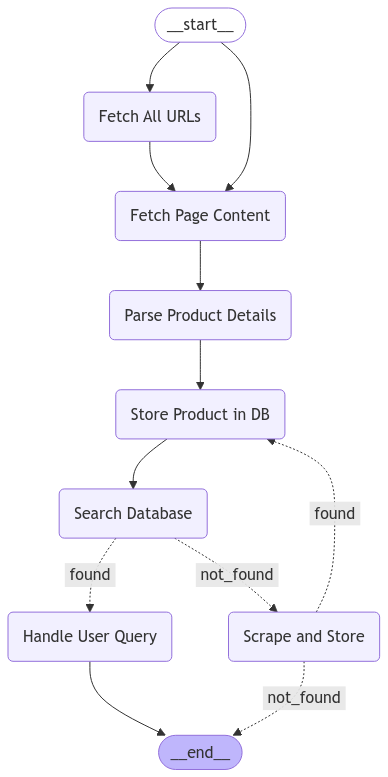

In [42]:
agent_workflow = StateGraph(PlanExecute)

affiliate_agent = AffiliateAgent()

agent_workflow.add_node("Fetch All URLs", affiliate_agent.fetch_all_urls)
agent_workflow.add_node("Fetch Page Content", affiliate_agent.fetch_page_content)
agent_workflow.add_node("Parse Product Details", affiliate_agent.parse_product_details)
agent_workflow.add_node("Store Product in DB", affiliate_agent.store_product_in_db)
agent_workflow.add_node("Search Database", affiliate_agent.search_database)
agent_workflow.add_node("Scrape and Store", affiliate_agent.scrape_and_store)
agent_workflow.add_node("Handle User Query", affiliate_agent.handle_user_query)

agent_workflow.set_entry_point("Fetch Page Content")
agent_workflow.set_entry_point("Fetch All URLs")
agent_workflow.add_edge("Fetch All URLs", "Fetch Page Content")
agent_workflow.add_edge("Fetch Page Content", "Parse Product Details")
agent_workflow.add_edge("Parse Product Details", "Store Product in DB")
agent_workflow.add_edge("Store Product in DB", "Search Database")

agent_workflow.add_conditional_edges(
    "Search Database",
    affiliate_agent.search_database,
    {
        "found": "Handle User Query",
        "not_found": "Scrape and Store"
    }
)

agent_workflow.add_conditional_edges(
    "Scrape and Store",
    affiliate_agent.scrape_and_store,
    {
        "found": "Store Product in DB",
        "not_found": END
    }
)

agent_workflow.add_edge("Handle User Query", END)

plan_and_execute_app = agent_workflow.compile()
display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))

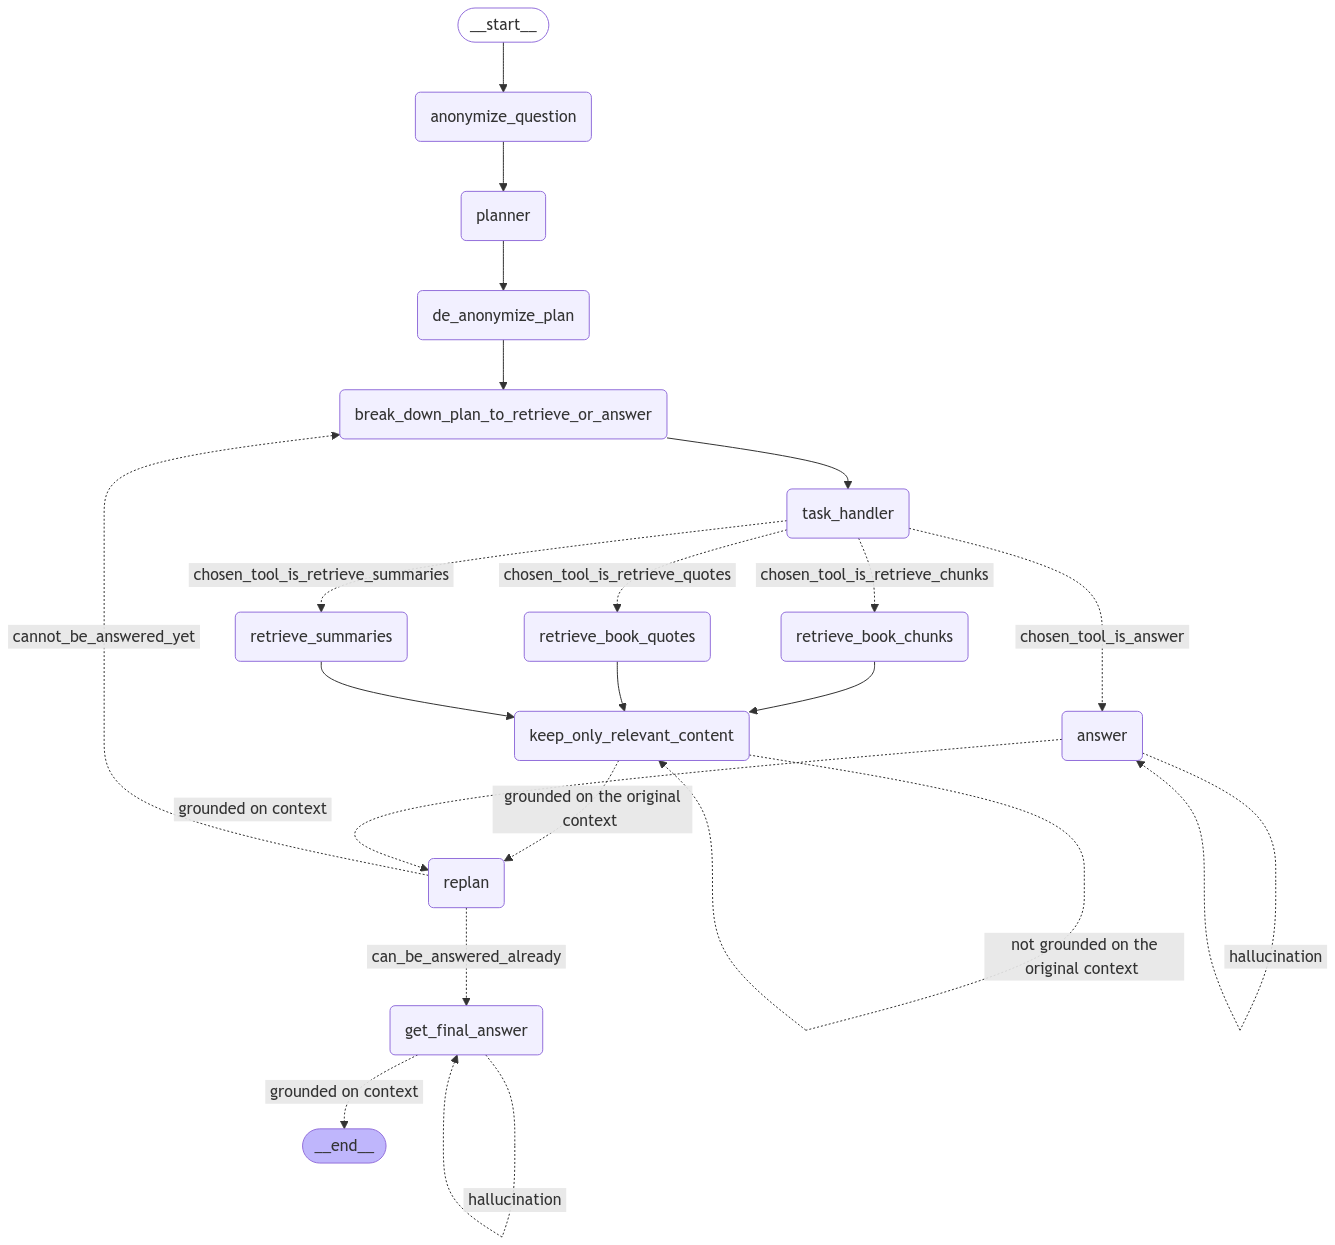

In [24]:
agent_workflow = StateGraph(PlanExecute)

# Add the anonymize node
agent_workflow.add_node("anonymize_question", anonymize_queries)

# Add the plan node
agent_workflow.add_node("planner", plan_step)

# Add the break down plan node

agent_workflow.add_node("break_down_plan_to_retrieve_or_answer", break_down_plan_step)

# Add the deanonymize node
agent_workflow.add_node("de_anonymize_plan", deanonymize_queries)

# Add the qualitative retrieval node
agent_workflow.add_node("retrieve_book_chunks", run_qualitative_chunks_retrieval_workflow)

agent_workflow.add_node("retrieve_summaries", run_qualitative_summaries_retrieval_workflow)

agent_workflow.add_node("retrieve_book_quotes", run_qualitative_quotes_retrieval_workflow)

# Add the qualitative answer node
agent_workflow.add_node("answer", run_qualtative_answer_workflow)

# Add the task handler node
agent_workflow.add_node("task_handler", run_task_handler_chain)

# Add a replan node
agent_workflow.add_node("replan", replan_step)

# Add answer from context node
agent_workflow.add_node("get_final_answer", run_qualtative_answer_workflow_for_final_answer)

agent_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)

# Build the graph

# Set the entry point
agent_workflow.set_entry_point("anonymize_question")

# From anonymize we go to plan
agent_workflow.add_edge("anonymize_question", "planner")

# # From plan we go to deanonymize
agent_workflow.add_edge("planner", "de_anonymize_plan")

# From deanonymize we go to break down plan to retrieve or answer
agent_workflow.add_edge("de_anonymize_plan", "break_down_plan_to_retrieve_or_answer")

# From break_down_plan we go to task handler to decide whether to retrieve or answer
agent_workflow.add_edge("break_down_plan_to_retrieve_or_answer", "task_handler")

# From task handler we go to either retrieve or answer
agent_workflow.add_conditional_edges("task_handler", retrieve_or_answer, {"chosen_tool_is_retrieve_chunks": "retrieve_book_chunks", "chosen_tool_is_retrieve_summaries":
                                                                            "retrieve_summaries", "chosen_tool_is_retrieve_quotes": "retrieve_book_quotes", "chosen_tool_is_answer": "answer"})

# From retrieve we go to keep_only_relevant_content to distill content
agent_workflow.add_edge("retrieve_book_chunks", "keep_only_relevant_content")

agent_workflow.add_edge("retrieve_summaries", "keep_only_relevant_content")

agent_workflow.add_edge("retrieve_book_quotes", "keep_only_relevant_content")

# distill content and check if it is grounded on context, if not grounded we distill the content again
agent_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {"grounded on the original context":"replan",
      "not grounded on the original context":"keep_only_relevant_content"},
    )

# After answering we go to replan if the answer is grounded on context, if not we answer again
agent_workflow.add_conditional_edges(
"answer",is_answer_grounded_on_context ,{"hallucination":"answer", "grounded on context":"replan"}

)

# After replanning we check if the question can be answered, if yes we go to get_final_answer, if not we go to task_handler
agent_workflow.add_conditional_edges("replan",can_be_answered, {"can_be_answered_already": "get_final_answer", "cannot_be_answered_yet": "break_down_plan_to_retrieve_or_answer"})


# After getting the final answer we check if the answer is grounded on context, if yes we go to END, if not we go to get_final_answer
agent_workflow.add_conditional_edges(
"get_final_answer",is_answer_grounded_on_context ,{"hallucination":"get_final_answer", "grounded on context":END}

)


plan_and_execute_app = agent_workflow.compile()

display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))